In [ ]:
import gzip
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
yjmob1 = 'yjmob100k-dataset1.csv.gz' # normal
yjmob1_df = pd.read_csv(yjmob1, compression='gzip')

# yjmob2 = 'yjmob100k-dataset2.csv.gz' # normal + disaster
# yjmob2_df = pd.read_csv(yjmob2, compression='gzip')

In [ ]:
def spatial_token(x, y):
    return (x-1)+(y-1)*200
yjmob1_df['combined_xy'] = yjmob1_df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1)

# K-Means (with Elbow Method) to Cluster Users

In [5]:
yjmob1_df.head(5) # display

,uid,d,t,x,y,combined_xy
0,0,0,1,79,86,17078
1,0,0,2,79,86,17078
2,0,0,8,77,86,17076
3,0,0,9,77,86,17076
4,0,0,19,81,89,17680


Aggregate only the first 100 step for each user for simplicity

In [6]:
yjmob1_df_chunked = [group[['uid', 't', 'combined_xy']].head(100) for _, group in yjmob1_df.groupby(by='uid')]

In [7]:
# load (loc, time) tuple data into a matrix
yjmob1_loctime = {}
for group in yjmob1_df_chunked:
    yjmob1_loctime_temp = group.apply(lambda row: (row['combined_xy'], row['t']), axis=1).tolist()
    yjmob1_loctime[group['uid'].iloc[0]]= yjmob1_loctime_temp

Select points to perform K-Means Clustering

In [10]:
# Select only location and time data points from 11AM or around 11AM
def select_data_point(data, target_time=22):  # time_range=(20, 25)
    # filtered_data = [(loc, time) for loc, time in data if time_range[0] <= time <= time_range[1]]
    # for loc, time in filtered_data:
    for loc, time in data:
        if time == target_time:
            return loc, time
    # if filtered_data:
        # closest_point = min(filtered_data, key=lambda x: abs(x[1] - target_time))
        # return closest_point
    # return None

# Transform the data to include only the selected data point
transformed_data = []
user_ids = []
for user_id, user_data in yjmob1_loctime.items():
    selected_point = select_data_point(user_data)
    if selected_point:
        transformed_data.append(selected_point)
        user_ids.append(user_id)

# Extract location and time for clustering, transformer type
transformed_data = np.array([[loc, time] for loc, time in transformed_data], dtype=float)
print(len(transformed_data))

95446


In [11]:
from scipy.cluster.vq import kmeans, vq

In [12]:
# Did several k-means clustering

inertia = []
for k in range(1, 11):
    centroids, distortion = kmeans(transformed_data, k)
    inertia.append(distortion)

Select 4 as the number of Clusters in the Whole Population

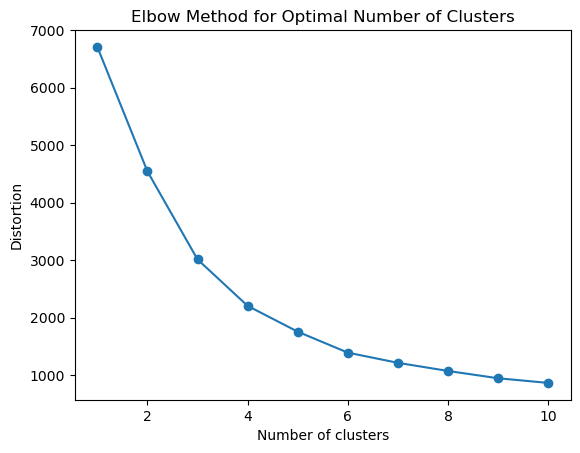

In [13]:
# Elbow method graph

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [14]:
# Do K-means with the best k
centroids, distortion = kmeans(transformed_data, 4)

# Assign each user to the nearest cluster
cluster_assignments, _ = vq(transformed_data, centroids)

# Store clustering result
user_cluster_df = pd.DataFrame({'uid': user_ids, 'cluster': cluster_assignments})

In [15]:
print(len(user_cluster_df[user_cluster_df['cluster']==0]),
      len(user_cluster_df[user_cluster_df['cluster']==1]),
      len(user_cluster_df[user_cluster_df['cluster']==2]),
      len(user_cluster_df[user_cluster_df['cluster']==3]))

26361 39698 20826 8561


Create a custom test and train dataset with randomly selected users from the data

With the whole `selected_users` I can do the horizontal train-test split

In [108]:
selected_users = []
for i in range(4):
    selected_users.append(user_cluster_df[user_cluster_df['cluster'] == i]['uid'].sample(n=250, random_state=123).tolist())

In [109]:
selected_uids = np.array(selected_users).flatten() # 100 users 
selected_uids

array([23571, 74204, 63696, 55441, 96426, 60824, 94235, 51631, 86909,
       42530, 48861, 84743, 35613, 69585, 75261, 23650, 79336, 94821,
       12931, 53463, 18040, 31206, 63322,  9171, 95444, 12150,  7366,
        3674, 16823, 10621, 63463, 17992, 57551, 80754, 99312, 94594,
       36907, 38247,  3951, 66781,  4785, 68770, 98780, 36850, 23834,
       47091, 92289, 37022, 88734, 52290, 98371, 30565,  2799, 92971,
       29639, 54873, 28204, 65041,  4148, 12363, 88515, 30343, 48408,
       94064, 49770,  4355, 98324, 70191, 24881, 51973, 36970,  2723,
       55443, 91833, 66652, 11398, 84277, 94400, 58734, 97420, 30074,
       53544, 58032, 81236, 92600, 70090, 22397, 13197, 73188, 76449,
       17326, 63919, 53835, 61898, 42864, 80041, 33526, 40935, 84723,
       52492, 25654,  6322, 96212,  1410, 53976, 13453, 76253, 21478,
       46157, 22565, 35585, 39060, 18637, 68772, 80634, 47406, 72532,
       63800, 85188, 71122, 37843, 38934, 71111, 42411, 36799, 20926,
       50518, 81605,

In [110]:
# Exported train-test split (horizontal)

selected_uids_df = yjmob1_df[yjmob1_df['uid'].isin(selected_uids)]
train_data = [group.head(100).iloc[:80] for _,group in selected_uids_df.groupby('uid')] # Train
test_data = [group.head(100).iloc[80:101] for _,group in selected_uids_df.groupby('uid')] # Test 

train_df = pd.concat(train_data)
test_df = pd.concat(test_data)
train_df.to_csv('df_train_1k.csv', index=False)
test_df.to_csv('df_test_1k.csv', index=False)

In [113]:
# Exported train-test split (vertical)

all_data = [group.head(100) for _,group in selected_uids_df.groupby('uid')] 
all_df = pd.concat(all_data)
all_df.to_csv('df_all_1k.csv', index=False)

# Data Processing

In [4]:
poi_description = pd.read_csv('POI_datacategories.csv', header=None) # Description
# poi_description.index = [(int(i)+1) for i in range(len(poi_description[0]))] # set index
# poi_description = poi_description.rename(columns={0:'Description'}) # set column title

poi_df = pd.read_csv('cell_POIcat.csv.gz', compression='gzip') # read POI data
poi_df['combined_xy'] = poi_df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1) # calculated location

# Match with the poi_df index with the poi_description
poi_df['POIcategory'] = poi_df['POIcategory']-1

# poi_df = pd.merge(poi, poi_description, left_on='POIcategory', right_index=True) # merge with description

# Visit frequency
loc_frequency = yjmob1_df['combined_xy'].value_counts()

In [97]:
data = {}
data['combined_xy'] = list(loc_frequency.index)  # len: 34032
data['visit_count'] = list(loc_frequency.values) # len: 34032
data = pd.DataFrame(data).sort_values(by='combined_xy', ignore_index=True)

In [98]:
for poi_descript_i in range(len(poi_description)):
    temp = poi_df[poi_df['POIcategory']==poi_descript_i].sort_values(by='combined_xy', ignore_index=True)[['POI_count', 'combined_xy']]
    data = data.merge(temp, on='combined_xy', how='left').fillna(0)
    data = data.rename(columns={'POI_count': poi_description.iloc[poi_descript_i].item().replace(' ', '_')})

In [99]:
data.head(5)

,combined_xy,visit_count,Food,Shopping,Entertainment,Japanese_restaurant,Western_restaurant,Eat_all_you_can_restaurant,Chinese_restaurant,Indian_restaurant,...,Accountant_Office,IT_Office,Publisher_Office,Building_Material,Gardening,Heavy_Industry,NPO,Utility_Copany,Port,Research_Facility
0,0,720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Importance of Visit Count - Pearson Corr Coef

In [ ]:
# Pearson Correlation Coefficient
# Treat the visit count as one variable and the likelihood of being at a specific location as another
# -- visit count could be obtained either by total
# -- likelihood of being at a specific location could be obtained either by (1) LSTM (2) Transformer


## Visit Frequency and POI Type (The more one kind of POI, the more visit count) - ANOVA and MLR
**Importance of POI Type to Frequency**

### ANOVA

In [100]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [148]:
formula = 'visit_count ~ ' + ' + '.join(data.columns[2:])
model = ols(formula, data=data).fit()
anova_results = sm.stats.anova_lm(model, typ=3) # assume some interactions between POIs

In [149]:
# collect only the significant results
anova_results = anova_results.sort_values(by=['PR(>F)', 'F', 'sum_sq']).drop(index='Intercept').dropna(subset=['PR(>F)', 'F', 'sum_sq'])
anova_results = anova_results[
    (anova_results['PR(>F)'] < 0.05) &
    (anova_results['F'] > np.percentile(anova_results['F'].dropna()[1:], 75))
]

### Correlation Matrix

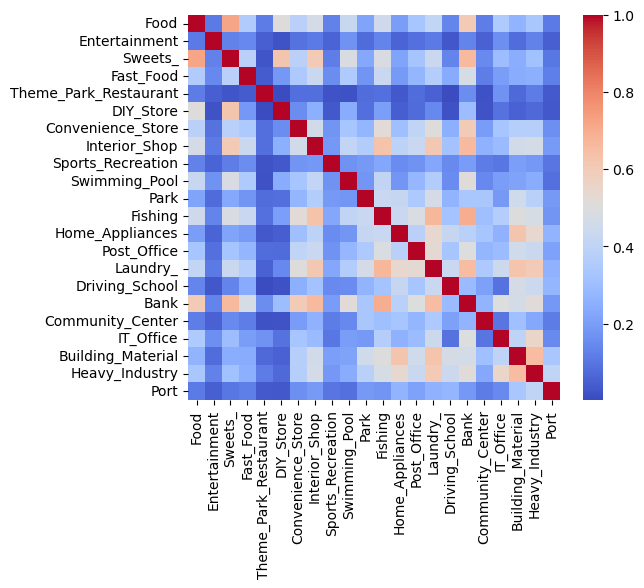

In [196]:
# inspect correlation
poi_corr = data[data.columns[data.columns.isin(anova_results.index.to_numpy())]].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(poi_corr, cmap='coolwarm')
plt.show()

In [241]:
poi_indices = poi_corr.iloc[0].index
poi_count = len(poi_corr)
significant_poi = dict(zip(poi_corr.columns, [1 for i in range(len(poi_corr.columns))]))
for i in range(poi_count):
    temp = poi_corr.iloc[i]
    for c in range(poi_count):
        temp_corr = temp.iloc[c]
        if ( (poi_indices[c] in significant_poi) and (temp_corr < 1) and (temp_corr > 0.7) ):
            significant_poi.pop(poi_indices[c])

print(significant_poi.keys())
print(len(significant_poi.keys()))

dict_keys(['Entertainment', 'Fast_Food', 'Theme_Park_Restaurant', 'DIY_Store', 'Convenience_Store', 'Interior_Shop', 'Sports_Recreation', 'Swimming_Pool', 'Park', 'Fishing', 'Home_Appliances', 'Post_Office', 'Laundry_', 'Driving_School', 'Bank', 'Community_Center', 'IT_Office', 'Building_Material', 'Heavy_Industry', 'Port'])
20


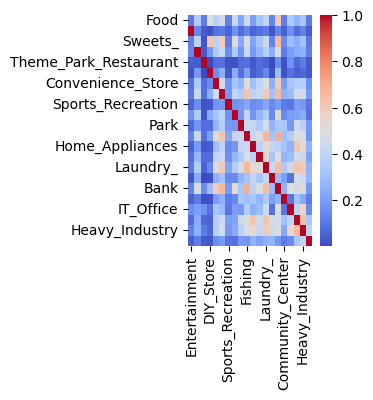

In [242]:
plt.figure(figsize=(2,3))
sns.heatmap(poi_corr[poi_corr.columns[poi_corr.columns.isin(significant_poi.keys())]], cmap='coolwarm')
plt.show()

### MLR

In [243]:
X = data[data.columns[data.columns.isin(significant_poi.keys())]]
Y = data['visit_count']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            visit_count   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     4218.
Date:                Fri, 21 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:19:53   Log-Likelihood:            -3.2488e+05
No. Observations:               34032   AIC:                         6.498e+05
Df Residuals:                   34011   BIC:                         6.500e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   820.68

## Delay: Time and POI Type (If people tend to go to certain places at certain times)

1. For each range of time
2. For all location
3. Caculate the average stay time (outlier can be considerate)
4. Calculate the corresponding POI category and POI count there
5. time: poi_category | poi_count | average_duration_of_stay

```
# time: 0
data_by_time = [time_group for t,time_group in yjmob1_df.groupby('t')][0]

for combined_xy,loc_group in data_by_time[0].groupby('combined_xy'):
    print([0, combined_xy, len(loc_group['uid'].unique())])

# location: 0
data_by_loc = [loc_group for loc,loc_group in yjmob1_df.groupby('combined_xy')][0]

# time: 8AM-10PM
total_people = 0
total_stay_time = 0
for uid, uid_group in data_by_loc[(data_by_loc['t']>=8*2) & (data_by_loc['t']<10*2)].groupby('uid'):
    total_people += 1
    total_stay_time += uid_group['t'].max() - uid_group['t'].min()
    
# average stay time
print(total_stay_time, total_people, total_stay_time/total_people)

# corresponding POIcategory and POI_count
display(poi_df[poi_df['combined_xy']==0][['POIcategory','POI_count']])
```